In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# DEMO

To implement canny's edge detection in pytorch first we have to figure out how the canny edge detection works.
This simple tutorial can show the general ideas of the algorithm

### Step 1 - Reading an image

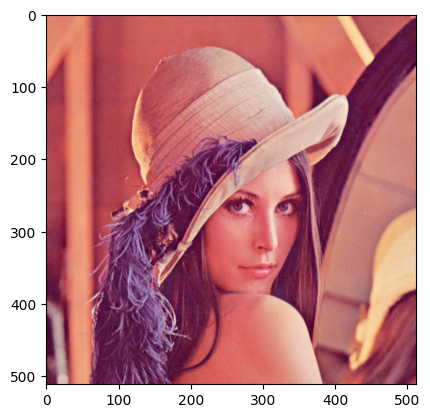

In [2]:
lena = cv2.imread("lena.png", cv2.IMREAD_COLOR)  # open an image file
lena = cv2.cvtColor(
    lena, cv2.COLOR_BGR2RGB
)  # lena.png comes in BGR format so we have to swap the colors to RGB for matplotlib
plt.imshow(lena)

### Step 2 - Greyscale conversion

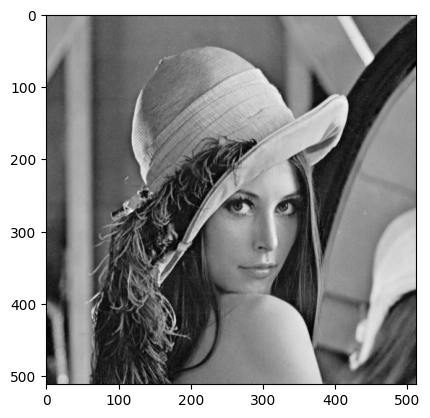

In [3]:
lena_bw = cv2.cvtColor(
    lena, cv2.COLOR_RGB2GRAY
)  # we can convert the image from RGB to grayscale with opencv
plt.imshow(lena_bw, cmap="gray")

### Step 3 - Implementing a gaussian kernel/filter

well known formula

\begin{equation}
\huge G(x,y) = \frac{1}{2 \pi \sigma ^{2}} e^{- \frac{x^{2} + y^{2}}{2 \sigma ^{2}}}
\end{equation}

In [4]:
def get_gaussian_kernel(k=3, sigma=1):
    # k parameter defines the size of gaussian filter (square shape)
    base_range = np.linspace(-1, 1, k) ** 2
    # x^2 + y^2 can be easily computed by using numpy reshapes
    xysqr = base_range + base_range.reshape(-1, 1)
    gaussian_kernel = np.exp(-xysqr / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    return gaussian_kernel / np.sum(gaussian_kernel)  # normalization

Gaussian kernel can be used to blurr out the image. This is useful because it removes very sharp edges and leaves only the noticeable ones

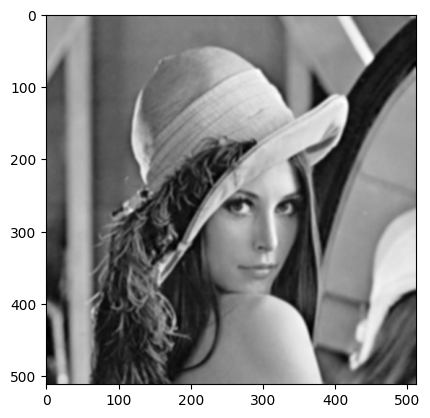

In [5]:
gaussian_k = get_gaussian_kernel(5).astype(np.float64)
lena_gaussian = cv2.filter2D(lena_bw, cv2.CV_64F, gaussian_k)
plt.imshow(lena_gaussian, cmap="gray")

### Step 4 - sobel kernels

Sobel kernel is a well known method to detect edges in x and y direction. It's essentially a derivative function in the form of a filter

In [6]:
def get_sobel_kernel_x():
    k = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return k.astype(np.float64)

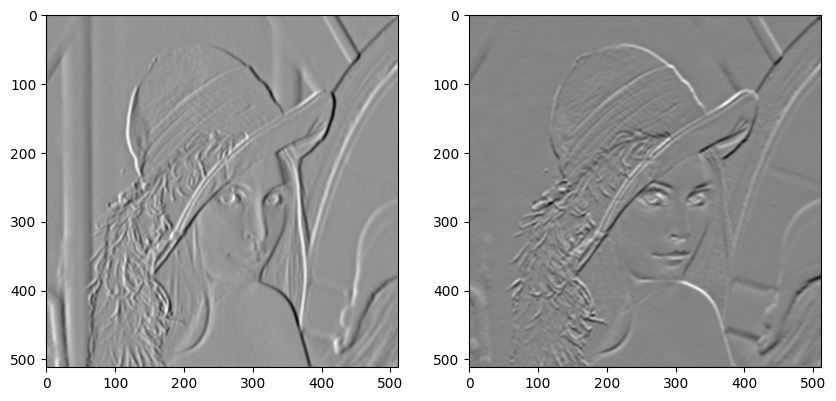

In [7]:
sobel_x = get_sobel_kernel_x()
sobel_y = sobel_x.T

lena_sobel_x = cv2.filter2D(lena_gaussian, -1, sobel_x)
lena_sobel_y = cv2.filter2D(lena_gaussian, -1, sobel_y)

f, ax = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(10)

ax[0].imshow(lena_sobel_x, cmap="gray")
ax[1].imshow(lena_sobel_y, cmap="gray")

In [8]:
lena_sobel_x.min()

-350.9396720904462

The above images represent the edge changes in x and y axis

### Step 5 - magnitude and angle of derivative

This is where the task becomes more challenging. We don't have much use from partial derivatives. For each pixel we need value of a combined derivative - the magnitude as well as slope's direction - thetha function

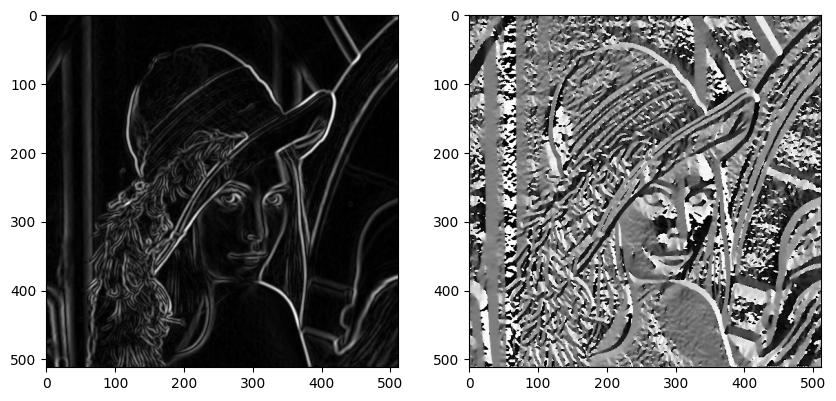

In [9]:
# we can compute the magnitude by using the Pitagoras' theorem
lena_G = np.sqrt(lena_sobel_x**2 + lena_sobel_y**2)
# we have to normalize the values of magnitude function
G_unscaled = lena_G
lena_G = (lena_G / lena_G.max()) * 255.0

# for this use case the arctan2 function works better
lena_theta = np.arctan2(lena_sobel_y, lena_sobel_x)

f, ax = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(10)

ax[0].imshow(lena_G, cmap="gray")
ax[1].imshow(lena_theta, cmap="gray")

### Step 6 - Nonmax suppression

nonmax kernels can be used to find local maximums of edges along 4 different axes
(moving in the south-north, east-west, southeast-northwest and southwest-northeast axis)

Each pair of kernels corresponds to one of these directions

In [10]:
nonmax_kernels = np.array(
    [
        [[[0, 0, 0], [0, 1, -1], [0, 0, 0]], [[0, 0, 0], [-1, 1, 0], [0, 0, 0]]],
        [[[-1, 0, 0], [0, 1, 0], [0, 0, 0]], [[0, 0, 0], [0, 1, 0], [0, 0, -1]]],
        [[[0, -1, 0], [0, 1, 0], [0, 0, 0]], [[0, 0, 0], [0, 1, 0], [0, -1, 0]]],
        [[[0, 0, 0], [0, 1, 0], [-1, 0, 0]], [[0, 0, -1], [0, 1, 0], [0, 0, 0]]],
    ]
)

nonmax_kernels

array([[[[ 0,  0,  0],
         [ 0,  1, -1],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [-1,  1,  0],
         [ 0,  0,  0]]],


       [[[-1,  0,  0],
         [ 0,  1,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  1,  0],
         [ 0,  0, -1]]],


       [[[ 0, -1,  0],
         [ 0,  1,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  1,  0],
         [ 0, -1,  0]]],


       [[[ 0,  0,  0],
         [ 0,  1,  0],
         [-1,  0,  0]],

        [[ 0,  0, -1],
         [ 0,  1,  0],
         [ 0,  0,  0]]]])

the simple code in the following part of the implementation maps values of theta functions to indices:
-pi/8 < x < pi/8 and x > 7pi/8 and x < -7pi/8 : 0
-3pi/8 < x < -pi/8 and 5pi/8 < x 7pi/8 : 1 
-5pi/8 < x < -3pi/8 and 3pi/8 < x < 5pi/8 : 2
-7pi/8 < x < -5pi/8 and pi/8 < x < 3pi/8 : 3

those indices correspond to proper nonmax kernels
This step is hard to explain in few words but there's plenty of information about it on the internet

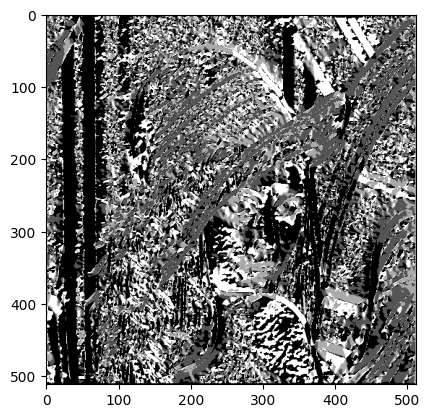

In [11]:
lena_new_theta = np.copy(lena_theta)
lena_new_theta[lena_new_theta < 0] += np.pi
lena_nonmax_kernel_indices = ((1 + 8 * lena_new_theta // (np.pi)) // 2) % 4

plt.imshow(lena_nonmax_kernel_indices, cmap="gray")

We can see that in the above image vertical edges are black, horizontal are light grey, southeast-northwest are white and southwest-northeast are dark grey

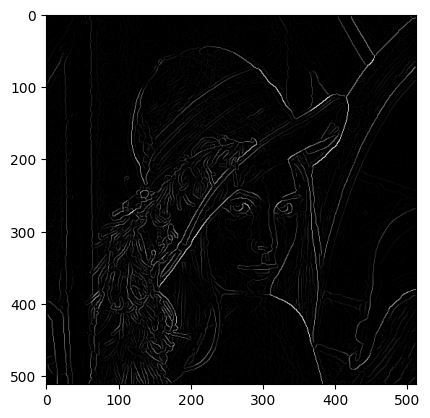

In [12]:
lena_thin_edge = np.copy(lena_G)

for nonmax_idx in range(4):
    local_max1 = cv2.filter2D(lena_G, cv2.CV_64F, nonmax_kernels[nonmax_idx][0]) > 0
    local_max2 = cv2.filter2D(lena_G, cv2.CV_64F, nonmax_kernels[nonmax_idx][1]) > 0
    local_max = (
        local_max1 * local_max2
    )  # we use maximums in both directions of the axis

    # then we remove the remaining values from the thick line image
    idx_to_remove = (local_max == False) * (lena_nonmax_kernel_indices == nonmax_idx)

    lena_thin_edge[idx_to_remove] = 0.0

plt.imshow(lena_thin_edge, cmap="gray")

resulting lines are thin. We  can directly compute the result from here by thresholding

### Step 7 - thresholding

We separate pixels into 3 categories. strong, weak and unimportant.
- We'll use a low threshold to cut out all pixels with values that are too low to be useful or considered as an edge
- The values higher than high threshold will be classified as strong - we'll display them on the final image
- Weak pixels come from between those 2 thresholds. We'll use hysteresis filter to determine whether we want to include them or not.

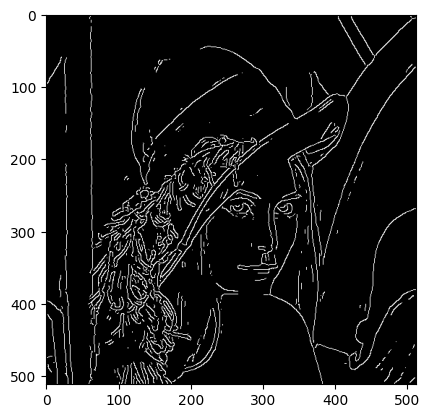

In [13]:
low_threshold = 0.15
high_threshold = 0.3

low_val = lena_thin_edge.max() * low_threshold
high_val = lena_thin_edge.max() * high_threshold

hysteresis_filter = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).astype(np.float64)
lena_hysteresis = cv2.filter2D(lena_thin_edge, cv2.CV_64F, hysteresis_filter) > 1

middle_candidates = (lena_thin_edge > low_val) * (lena_thin_edge <= high_val)
high_values = (lena_thin_edge > high_val) + lena_hysteresis * middle_candidates

lena_threshold = np.zeros(lena_thin_edge.shape) + high_values

# plt.figure(figsize=(10,10))
plt.imshow(lena_threshold, cmap="gray")

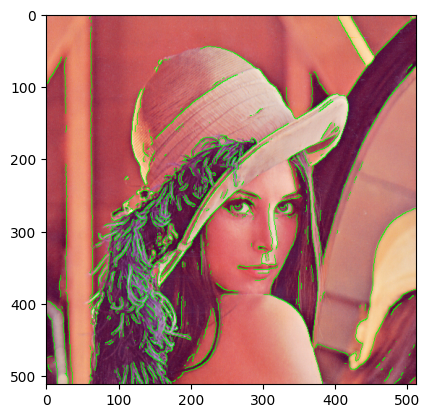

In [14]:
new_lena = np.copy(lena)
new_lena[:, :, 0][lena_threshold == 1] = 0
new_lena[:, :, 1][lena_threshold == 1] = 255
new_lena[:, :, 2][lena_threshold == 1] = 0

plt.imshow(new_lena, cmap="gray")

Beautiful. I wonder what the full version of lena.png looks like

# Torch implementation

In [15]:
from torch import nn
import torch

In [16]:
class CannyEdgeDetection(nn.Module):
    def __init__(
        self,
        gaussian_kernel_size=3,
        gaussian_kernel_sigma=1,
        low_threshold=0.05,
        high_threshold=0.3,
        use_cuda=False,
    ):
        super().__init__()
        self.device = "cuda" if use_cuda else "cpu"

        self.low_threshold = low_threshold
        self.high_threshold = high_threshold

        self.bw_conv = nn.Conv2d(
            in_channels=3, out_channels=1, kernel_size=1, padding=0, bias=False
        )
        rgb_to_bw_kernel = torch.tensor([0.3, 0.59, 0.11], dtype=torch.float64)
        self.bw_conv.weight = nn.Parameter(rgb_to_bw_kernel.reshape([1, 3, 1, 1]))

        self.gaussian_blur = nn.Conv2d(
            in_channels=1,
            out_channels=1,
            kernel_size=gaussian_kernel_size,
            padding=gaussian_kernel_size // 2,
            bias=False,
        )
        gaussian_kernel = self.get_gaussian_kernel(
            gaussian_kernel_size, gaussian_kernel_sigma
        )
        self.gaussian_blur.weight = nn.Parameter(
            torch.from_numpy(gaussian_kernel.astype(np.float64)).reshape(
                1, 1, gaussian_kernel_size, gaussian_kernel_size
            )
        )

        sobel_kernel = np.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]])
        self.sobel_filter = nn.Conv2d(
            in_channels=1, out_channels=2, kernel_size=3, padding=1, bias=False
        )
        self.sobel_filter.weight = nn.Parameter(
            torch.from_numpy(np.stack([sobel_kernel, sobel_kernel.T])).reshape(
                2, 1, 3, 3
            )
        )

        nonmax_kernels = np.array(
            [
                [[0, 0, 0], [0, 1, -1], [0, 0, 0]],
                [[0, 0, 0], [-1, 1, 0], [0, 0, 0]],
                [[-1, 0, 0], [0, 1, 0], [0, 0, 0]],
                [[0, 0, 0], [0, 1, 0], [0, 0, -1]],
                [[0, -1, 0], [0, 1, 0], [0, 0, 0]],
                [[0, 0, 0], [0, 1, 0], [0, -1, 0]],
                [[0, 0, 0], [0, 1, 0], [-1, 0, 0]],
                [[0, 0, -1], [0, 1, 0], [0, 0, 0]],
            ]
        )
        self.directional_filter = nn.Conv2d(
            in_channels=1, out_channels=8, kernel_size=3, padding=1, bias=False
        )
        self.directional_filter.weight = nn.Parameter(
            torch.from_numpy(nonmax_kernels.astype(np.float64)).reshape(8, 1, 3, 3)
        )

        hysteresis_filter = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
        self.hysteresis = nn.Conv2d(
            in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False
        )
        self.hysteresis.weight = nn.Parameter(
            torch.from_numpy(hysteresis_filter.astype(np.float64)).reshape(1, 1, 3, 3)
        )

    def get_gaussian_kernel(self, gaussian_kernel_size, gaussian_kernel_sigma):
        base_range = np.linspace(-1, 1, gaussian_kernel_size) ** 2
        xysqr = base_range + base_range.reshape(-1, 1)
        gaussian_kernel = np.exp(-xysqr / (2 * gaussian_kernel_sigma**2)) / (
            2 * np.pi * gaussian_kernel_sigma**2
        )
        return gaussian_kernel / np.sum(gaussian_kernel)

    def forward(self, img):
        transpose_img = np.transpose(img, (2, 0, 1))
        img4d = torch.tensor(transpose_img.astype(np.float64))

        bw = self.bw_conv(img4d)

        blurred = self.gaussian_blur(bw)

        gradients = self.sobel_filter(blurred)

        Gx, Gy = gradients[0], gradients[1]

        G = torch.sqrt(Gx**2 + Gy**2).reshape(1, 1, transpose_img.shape[1], -1)
        G = (G / G.max()) * 255
        theta = torch.atan2(Gy, Gx)

        theta_new = theta.clone()
        theta_new[theta_new < 0] += np.pi
        nonmax_idx = ((1 + 8 * theta_new // (np.pi)) // 2) % 4

        directional = self.directional_filter(G) > 0

        thin_edges = G.clone().squeeze()

        for i in range(4):
            local_max = torch.logical_and(
                directional[0, 2 * i], directional[0, 2 * i + 1]
            )
            idx_to_remove = (local_max == False) * (i == nonmax_idx)
            thin_edges[idx_to_remove] = 0.0

        low_val = thin_edges.max() * self.low_threshold
        high_val = thin_edges.max() * self.high_threshold

        hysteriesis_output = (
            self.hysteresis((thin_edges.expand(1, 1, thin_edges.shape[0], -1))) > 1
        )

        middle_candidates = (thin_edges > low_val) * (thin_edges <= high_val)
        high_values = (thin_edges > high_val) + hysteriesis_output * middle_candidates

        post_threshold = (torch.zeros(thin_edges.shape) + high_values).squeeze()

        result_img = torch.tensor(img)

        # return result_img.shape
        result_img[:, :, 0][post_threshold == 1] = 0
        result_img[:, :, 1][post_threshold == 1] = 255
        result_img[:, :, 2][post_threshold == 1] = 0

        return (
            bw,
            blurred,
            Gx,
            Gy,
            G,
            theta,
            theta_new,
            nonmax_idx,
            thin_edges,
            post_threshold,
            result_img,
        )

In [17]:
edge_detection = CannyEdgeDetection(5)
output = edge_detection.forward(lena)
output = [o.detach().numpy().squeeze() for o in output]
output

[array([[162.38, 162.38, 162.36, ..., 169.74, 155.1 , 128.31],
        [162.38, 162.38, 162.36, ..., 169.74, 155.1 , 128.31],
        [162.38, 162.38, 162.36, ..., 169.74, 155.1 , 128.31],
        ...,
        [ 42.42,  42.42,  49.91, ..., 104.21, 100.08,  98.37],
        [ 43.85,  43.85,  54.5 , ..., 103.69, 105.1 , 108.07],
        [ 43.85,  43.85,  54.5 , ..., 103.69, 105.1 , 108.07]]),
 array([[ 63.56782027,  85.99524831, 101.43912866, ..., 100.49814184,
          82.13958925,  57.90265868],
        [ 86.10610203, 116.48528443, 137.40486814, ..., 136.13024983,
         111.26258258,  78.43232967],
        [101.59642144, 137.44075936, 162.12373528, ..., 160.61981563,
         131.27850366,  92.54215244],
        ...,
        [ 29.29714973,  40.34318232,  48.93361621, ..., 100.10207265,
          85.18660011,  63.04676709],
        [ 24.36084095,  33.87727134,  41.37941438, ...,  86.61887053,
          73.71292709,  54.68792452],
        [ 17.97283642,  25.07185695,  30.69479287, ...

In [18]:
cv2_output = [
    lena_bw,
    lena_gaussian,
    lena_sobel_x,
    lena_sobel_y,
    lena_G,
    lena_theta,
    lena_new_theta,
    lena_nonmax_kernel_indices,
    lena_thin_edge,
    lena_threshold,
    new_lena,
]

titles = [
    "greyscale conversion",
    "gaussian blur",
    "sobel filter x",
    "sobel filter y",
    "magnitude",
    "orientation",
    "direction",
    "nonmax idx",
    "thin edges",
    "thresholding",
    "final edges",
]

In [19]:
for i in range(9):
    print(titles[i])
    print("min", cv2_output[i].min(), output[i].min())
    print("max", cv2_output[i].max(), output[i].max())
    print()

greyscale conversion
min 25 24.79
max 245 245.15999999999997

gaussian blur
min 30.440377583243922 17.972836420464255
max 230.15755029781945 230.2025089803806

sobel filter x
min -350.9396720904462 -723.3865191247769
max 256.46167723557284 584.118814337597

sobel filter y
min -304.3546625143703 -717.7215022825234
max 281.89562088781554 740.004919272819

magnitude
min 0.0 0.01003691194053235
max 255.0 255.0

orientation
min -3.141592653589793 -3.141584744255542
max 3.141592653589793 3.141578229044898

direction
min 0.0 7.909334251099409e-06
max 3.141592653589793 3.1415926030632146

nonmax idx
min 0.0 0.0
max 3.0 3.0

thin edges
min 0.0 0.0
max 255.0 255.0


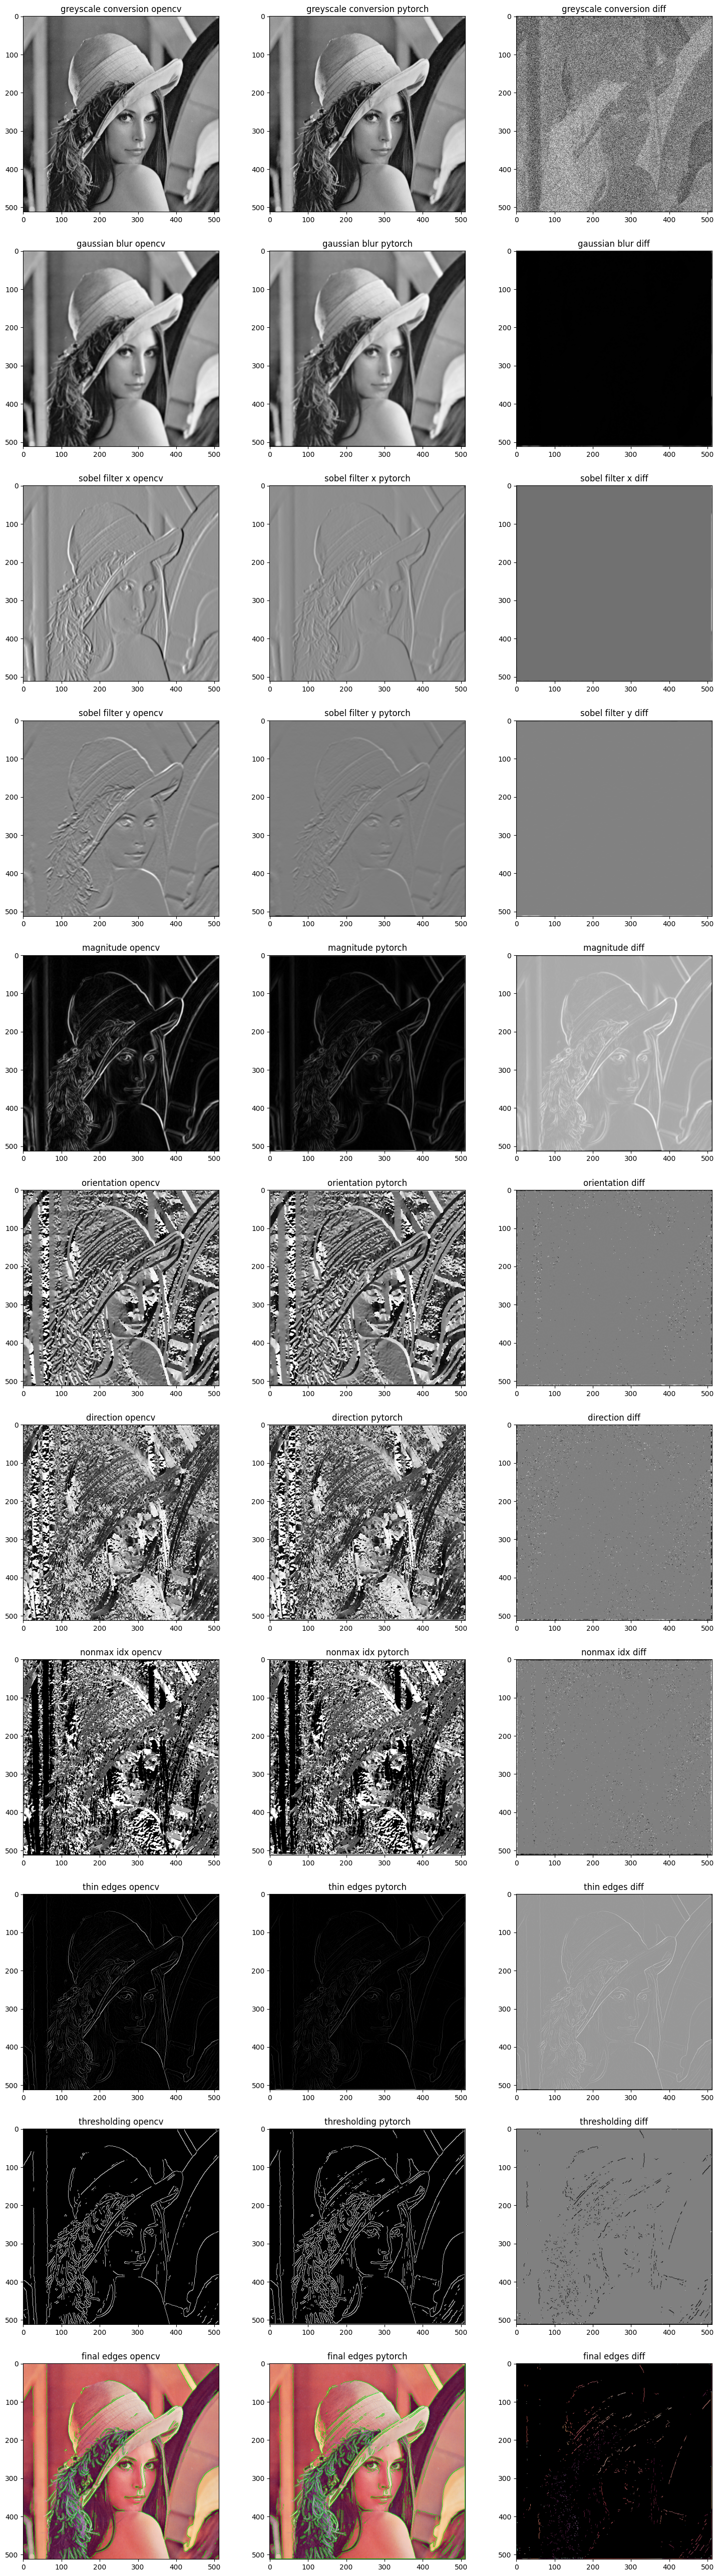

In [20]:
f, ax = plt.subplots(11, 3)
f.set_figheight(66)
f.set_figwidth(18)


for i in range(11):
    title = titles[i]
    ax[i][0].imshow(cv2_output[i], cmap="gray")
    ax[i][0].set_title(title + " opencv")
    ax[i][1].imshow(output[i], cmap="gray")
    ax[i][1].set_title(title + " pytorch")
    ax[i][2].imshow(cv2_output[i] - output[i], cmap="gray")
    ax[i][2].set_title(title + " diff")

plt.show()